In [32]:
# BLOCK 0 – Gerekli kütüphanelerin kurulumu (bir kere çalıştırman yeter)
!pip install pandas sentinelhub rasterio matplotlib


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\doruk\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [44]:
import pandas as pd
from datetime import datetime, timedelta

df = pd.read_csv("fire_nrt_J1V-C2_684138.csv")

df["acq_datetime"] = pd.to_datetime(
    df["acq_date"].astype(str) + " " + df["acq_time"].astype(str).str.zfill(4),
    format="%Y-%m-%d %H%M"
)

df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,acq_datetime
0,66.54968,76.69383,349.77,0.78,0.78,2025-11-03,102,N20,VIIRS,n,2.0NRT,264.76,12.22,N,2025-11-03 01:02:00
1,67.84235,79.97705,323.01,0.68,0.74,2025-11-03,102,N20,VIIRS,n,2.0NRT,252.59,2.41,N,2025-11-03 01:02:00
2,68.41514,83.62517,331.43,0.65,0.73,2025-11-03,102,N20,VIIRS,n,2.0NRT,259.89,6.94,N,2025-11-03 01:02:00
3,66.55634,76.68800,346.86,0.77,0.78,2025-11-03,102,N20,VIIRS,n,2.0NRT,261.19,12.22,N,2025-11-03 01:02:00
4,68.41590,83.63245,338.11,0.65,0.73,2025-11-03,102,N20,VIIRS,n,2.0NRT,259.79,7.29,N,2025-11-03 01:02:00


In [51]:
# BLOCK 2 – Yangın verilerini hücrelere ayır ve gruplandır
df['lat_cell'] = (df['latitude'] / 0.05).round().astype(int)
df['lon_cell'] = (df['longitude'] / 0.05).round().astype(int)

df['date'] = df['acq_datetime'].dt.date
groups = df.groupby(['date', 'lat_cell', 'lon_cell'])

events = []

for (date, lat_cell, lon_cell), g in groups:

    lat_min = g['latitude'].min()
    lat_max = g['latitude'].max()
    lon_min = g['longitude'].min()
    lon_max = g['longitude'].max()

    buffer = 0.02
    lat_min -= buffer
    lat_max += buffer
    lon_min -= buffer
    lon_max += buffer

    t_start = datetime.combine(date, datetime.min.time()) - timedelta(days=1)
    t_end   = datetime.combine(date, datetime.max.time()) + timedelta(days=1)

    events.append({
        "bbox": [lon_min, lat_min, lon_max, lat_max],
        "time_interval": (t_start.strftime("%Y-%m-%d"), t_end.strftime("%Y-%m-%d")),
        "n_firms_points": len(g)
    })

len(events)

108779

In [ ]:
events = sorted(events, key=lambda e: e["n_firms_points"], reverse=True)

TOP_N = 50

events = events[:TOP_N]
print("Seçilen event sayısı:", len(events))
events[:3]

Seçilen event sayısı: 50


[{'bbox': [np.float64(116.00571000000001),
   np.float64(-33.6884),
   np.float64(116.09389),
   np.float64(-33.60501)],
  'time_interval': ('2025-11-08', '2025-11-10'),
  'n_firms_points': 177},
 {'bbox': [np.float64(29.15522),
   np.float64(-1.44443),
   np.float64(29.24458),
   np.float64(-1.35572)],
  'time_interval': ('2025-11-08', '2025-11-10'),
  'n_firms_points': 161},
 {'bbox': [np.float64(29.1553),
   np.float64(-1.44468),
   np.float64(29.24493),
   np.float64(-1.35847)],
  'time_interval': ('2025-11-07', '2025-11-09'),
  'n_firms_points': 136}]

In [53]:
from sentinelhub import SHConfig, SentinelHubCatalog, BBox, CRS, DataCollection

config = SHConfig()
config.sh_client_id = "d582ede6-aa36-4e58-b607-162d333d9d19"
config.sh_client_secret = "eiojycDQr6FzktTpqLgO7N3uFQckVr7R"

catalog = SentinelHubCatalog(config=config)

print("Sentinel Hub bağlantısı hazır!")

Sentinel Hub bağlantısı hazır!


In [54]:
s2_events = []
rate_limit = 10

for ev in events:
    if rate_limit <= 0:
        break
    rate_limit -= 1

    bbox = BBox(ev["bbox"], crs=CRS.WGS84)
    t_int = ev["time_interval"]

    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=bbox,
        time=t_int,
        fields={
            "include": ["id", "properties.datetime", "properties.eo:cloud_cover"],
            "exclude": []
        },
        limit=10
    )

    items = list(search_iterator)

    # Bulut < 70% olanları al
    items = [it for it in items if it["properties"].get("eo:cloud_cover", 100) < 70]

    if not items:
        continue

    s2_events.append({
        "firms_event": ev,
        "s2_items": items
    })

len(s2_events)


6

In [55]:
for e in s2_events[:5]:
    print("FIRMS event:", e['firms_event']['time_interval'], e['firms_event']['bbox'])
    for it in e['s2_items']:
        print("  S2:", it['id'], it['properties']['datetime'], "cloud:", it['properties']['eo:cloud_cover'])
    print()

FIRMS event: ('2025-11-08', '2025-11-10') [np.float64(116.00571000000001), np.float64(-33.6884), np.float64(116.09389), np.float64(-33.60501)]
  S2: S2A_MSIL2A_20251110T020501_N0511_R017_T50HLH_20251110T073109 2025-11-10T02:17:29Z cloud: 0.06
  S2: S2A_MSIL2A_20251110T020501_N0511_R017_T50HMH_20251110T073109 2025-11-10T02:17:25Z cloud: 3.46
  S2: S2C_MSIL2A_20251108T020321_N0511_R017_T50HLH_20251108T060511 2025-11-08T02:17:26Z cloud: 40.78
  S2: S2C_MSIL2A_20251108T020321_N0511_R017_T50HMH_20251108T060511 2025-11-08T02:17:21Z cloud: 53.14

FIRMS event: ('2025-11-07', '2025-11-09') [np.float64(29.1553), np.float64(-1.44468), np.float64(29.24493), np.float64(-1.35847)]
  S2: S2B_MSIL2A_20251107T081039_N0511_R078_T35MQU_20251107T100517 2025-11-07T08:30:33Z cloud: 66.74

FIRMS event: ('2025-11-05', '2025-11-07') [np.float64(124.30518000000001), np.float64(-21.79265), np.float64(124.39448), np.float64(-21.70561)]
  S2: S2A_MSIL2A_20251107T015641_N0511_R117_T51KXR_20251107T065804 2025-11-07T

In [56]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, bbox_to_dimensions

evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B08", "B12", "SCL"],
    output: { bands: 4, sampleType: "FLOAT32" }
  };
}
function evaluatePixel(sample) {
  return [sample.B04, sample.B08, sample.B12, sample.SCL];
}
"""

def download_s2_for_event(event_idx, ev, item, out_dir):
    bbox = BBox(ev["bbox"], crs=CRS.WGS84)
    resolution = 20
    size = bbox_to_dimensions(bbox, resolution=resolution)

    acq_date = item["properties"]["datetime"][:10]

    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(acq_date, acq_date),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
        data_folder=out_dir,
    )

    arr = request.get_data(save_data=True)[0]
    filenames = request.get_filename_list()

    print(f"Saved files for event {event_idx}:")
    for f in filenames:
        print("  ", f)

    return arr, filenames

# İndir
for idx, e in enumerate(s2_events):
    ev = e["firms_event"]
    item = e["s2_items"][0]
    download_s2_for_event(idx, ev, item, "s2_fire_event_tiffs")


Saved files for event 0:
   e579dd9b61dbf86cda6b83c7df517a6a\response.tiff
Saved files for event 1:
   4fabe5cb99a5573399c445391389acb1\response.tiff
Saved files for event 2:
   ab405edbc2583338bdd5b1ebd869dd53\response.tiff
Saved files for event 3:
   49dc5be0695660bcb65a1a36801b70e4\response.tiff
Saved files for event 4:
   fba0d0e2e99fc9804c584e107a76dcf6\response.tiff
Saved files for event 5:
   c74c9a322aab41692e444071ba6fa0a2\response.tiff


Toplam TIFF: 6
Gösterilen: s2_fire_event_tiffs\49dc5be0695660bcb65a1a36801b70e4\response.tiff
Bands: 4


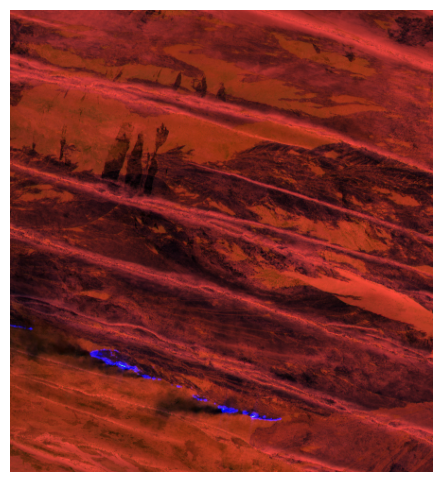

In [64]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

folder = "s2_fire_event_tiffs"

tiffs = []
for root, _, files in os.walk(folder):
    for f in files:
        if f.endswith(".tiff") or f.endswith(".tif"):
            tiffs.append(os.path.join(root, f))

print("Toplam TIFF:", len(tiffs))

index = 0
path = tiffs[index]
print("Gösterilen:", path)

with rasterio.open(path) as src:
    img = src.read().astype(np.float32)

print("Bands:", img.shape[0])

# Eğer 4 bant varsa RGB’yi B04-B03-B02’den oluştur
if img.shape[0] >= 3:
    r, g, b = img[0], img[1], img[2]

    # Normalizasyon
    def norm(x):
        x = x - x.min()
        if x.max() > 0:
            x = x / x.max()
        return x

    rgb = np.dstack([norm(r), norm(g), norm(b)])

    plt.figure(figsize=(6,6))
    plt.imshow(rgb)
    plt.axis("off")
    plt.show()